In [273]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score
import random

In [274]:
# Load dataset
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [275]:
# Helper function to ensure gamma is either 'scale', 'auto', or a positive number 
def get_valid_gamma():
    # Ensures that gamma is either 'scale', 'auto', or a positive number
    gamma_value = np.random.uniform(-5, 5)  # Ggenerating a random value, but it may be invalid
    if gamma_value < 0:  # If gamma is negative, choose between 'scale' and 'auto'
        return np.random.choice(['scale', 'auto'])
    else:
        return max(0.0, gamma_value)  

In [276]:
# Fitness function: evaluates SVM performance based on parameters
# params[0] = C, params[1] = gamma

def fitness_functionn(params, X_train, y_train, X_test, y_test):
    C = params[0]
    gamma = get_valid_gamma()
    model = SVC(C=C, gamma=gamma)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average='macro')

In [277]:
def fitness_function(params, X_train, y_train, X_test, y_test):
    C = params[0]
    gamma = get_valid_gamma() 

    try:
        # Initializing the SVC classifier with parameters
        model = SVC(C=C, gamma=gamma)

        # Model training
        model.fit(X_train, y_train)

        # Forecasting and evaluation
        y_pred = model.predict(X_test)

        return accuracy_score(y_test, y_pred)
    except Exception as e:
        print("Error in the model:", e)
        return 0

### GENETIC ALGORITHM ###

In [278]:
def genetic_algorithm(fitness_func, population_size=10, generations=20, mutation_rate=0.2):
    population = [np.random.uniform(0.1, 100, size=2) for _ in range(population_size)]
    best_scores = []

    for gen in range(generations):
        scores = [fitness_func(ind) for ind in population]
        best_scores.append(np.max(scores))

        # Selection: Top 50%
        sorted_indices = np.argsort(scores)[::-1]
        selected = [population[i] for i in sorted_indices[:population_size // 2]]

        # Crossover + Mutation
        children = []
        while len(children) < population_size:
            parent1, parent2 = random.sample(selected, 2)
            crossover = np.array([
                parent1[0] if random.random() < 0.5 else parent2[0],
                parent1[1] if random.random() < 0.5 else parent2[1]
            ])
            if random.random() < mutation_rate:
                mutation = np.random.uniform(-1, 1, size=2)
                crossover += mutation
            crossover = np.clip(crossover, 0.1, 100)
            children.append(crossover)
        population = children

    best_params = population[np.argmax(scores)]
    return best_params, best_scores

### PARTICLE SWARM OPTIMIZATION ###

In [279]:
def particle_swarm_optimization(fitness_func, swarm_size=10, iterations=20):

    # Initialization of particles
    particles = [np.random.uniform(0.1, 100, size=2) for _ in range(swarm_size)]
    velocities = [np.zeros(2) for _ in range(swarm_size)]
    personal_best = particles.copy()
    global_best = particles[0]

    # Fitness assessment for initial particles
    global_best_score = fitness_func(global_best)
    scores_history = []

    for _ in range(iterations):
        for i, particle in enumerate(particles):
            score = fitness_func(particle)
            if score > fitness_func(personal_best[i]):
                personal_best[i] = particle
            if score > global_best_score:
                global_best = particle
                global_best_score = score
        scores_history.append(global_best_score)

        # Updating particle velocities and positions
        for i in range(swarm_size):
            r1, r2 = np.random.rand(), np.random.rand()
            velocities[i] = (0.5 * velocities[i] +
                             r1 * (personal_best[i] - particles[i]) +
                             r2 * (global_best - particles[i]))
            particles[i] += velocities[i]
            particles[i] = np.clip(particles[i], 0.1, 100)

    return global_best, scores_history

### ARTIFICIAL IMMUNE SYSTEM ###

In [280]:
def artificial_immune_system(fitness_func, population_size=10, generations=20, clone_factor=5):
    antibodies = [np.random.uniform(0.1, 100, size=2) for _ in range(population_size)]
    best_scores = []

    for _ in range(generations):
        clone_pool = []

        # Cloning of antibodies
        for ab in antibodies:
            clones = [ab + np.random.normal(0, 5, size=2) for _ in range(clone_factor)]
            clones = [np.clip(cl, 0.1, 100) for cl in clones]
            clone_pool.extend(clones)

        clone_scores = [fitness_func(params) for params in clone_pool]
        top_indices = np.argsort(clone_scores)[-population_size:]
        antibodies = [clone_pool[i] for i in top_indices]
        best_scores.append(max(clone_scores))

    best_ab = antibodies[np.argmax([fitness_func(ab) for ab in antibodies])]
    return best_ab, best_scores


 Let us run all optimizers

In [281]:
print("Running Genetic Algorithm...")
ga_params, ga_scores = genetic_algorithm(lambda p: fitness_function(p, X_train, y_train, X_test, y_test))

print("Running PSO...")
pso_params, pso_scores = particle_swarm_optimization(lambda p: fitness_function(p, X_train, y_train, X_test, y_test))

print("Running AIS...")
ais_params, ais_scores = artificial_immune_system(lambda p: fitness_function(p, X_train, y_train, X_test, y_test))

Running Genetic Algorithm...
Running PSO...
Running AIS...


In [282]:
#Final evaluation
def evaluate_model(params):
    model = SVC(C=params[0], gamma=params[1])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred, average='macro'),
        'f1_score': f1_score(y_test, y_pred, average='macro')
    }

In [283]:
ga_eval = evaluate_model(ga_params)
pso_eval = evaluate_model(pso_params)
ais_eval = evaluate_model(ais_params)

In [284]:
# Evaluation results
results = {
    "Algorithm": ["Genetic Algorithm", "Particle Swarm Optimization", "Artificial Immune System"],
    "Accuracy": [ga_eval["accuracy"], pso_eval["accuracy"], ais_eval["accuracy"]],
    "Recall": [ga_eval["recall"], pso_eval["recall"], ais_eval["recall"]],
    "F1 Score": [ga_eval["f1_score"], pso_eval["f1_score"], ais_eval["f1_score"]],
}

df_results = pd.DataFrame(results)

print("\nFinal Performance Metrics:\n")
print(df_results.to_string(index=False))



Final Performance Metrics:

                  Algorithm  Accuracy   Recall  F1 Score
          Genetic Algorithm  0.600000 0.619433  0.596441
Particle Swarm Optimization  0.800000 0.817814  0.808307
   Artificial Immune System  0.955556 0.964912  0.957672


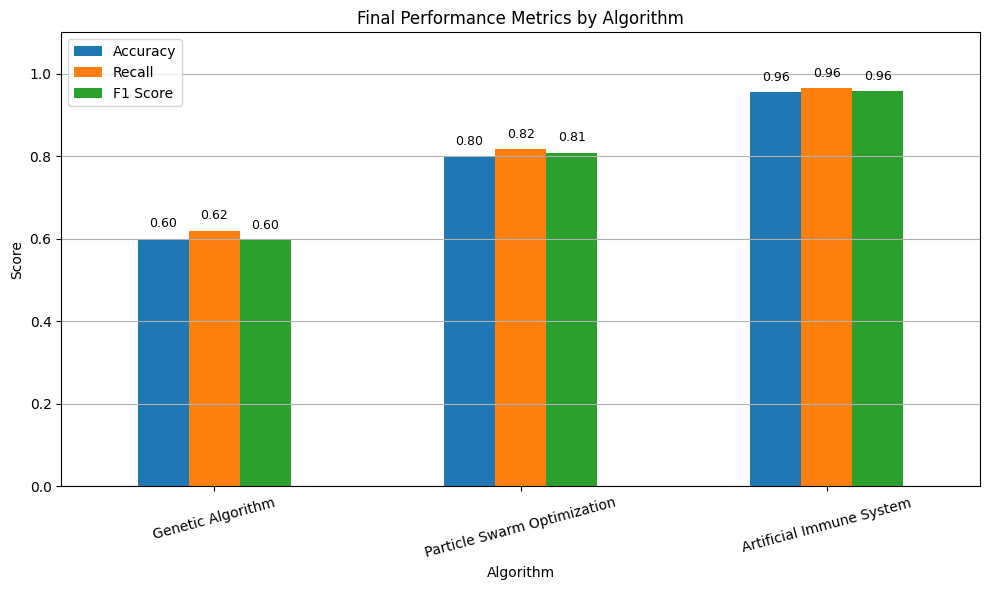

In [285]:
ax = df_results.set_index("Algorithm").plot(kind="bar", figsize=(10, 6))
plt.title("Final Performance Metrics by Algorithm")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.grid(axis='y')
plt.xticks(rotation=15)
plt.tight_layout()

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,  
            height + 0.02,                      
            f"{height:.2f}",                    
            ha='center', va='bottom', fontsize=9
        )

plt.show()
